In [1]:
import glob
import os
import time
import csv

# os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID' 
# os.environ['CUDA_VISIBLE_DEVICES']='0,1,2,3'
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from stargan2.solver_multi_GPU import Solver

import numpy as np

import matplotlib.pyplot as plt
import torch
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset

import torchvision.models.resnet as resnet

from torch.backends import cudnn
cudnn.benchmark = True

In [2]:
import torchvision.datasets as datasets
from itertools import groupby
import random
from torch.utils.data.sampler import WeightedRandomSampler

class BinRefDataset(torch.utils.data.Dataset):
    def __init__(self, X0, X1):
        super().__init__()
        
        self.X = torch.from_numpy(np.concatenate([X0, X1]))
        
        x0_l = len(X0)
        x1_l = len(X1)

        self.y = torch.tensor([0]*x0_l + [1]*x1_l)
        
        idx1 = list(range(x0_l))
        idx2 = random.sample(idx1, x0_l)
        self.idx = list(zip(idx1, idx2))
        
        idx1 = range(x0_l, x0_l+x1_l)
        idx2 = random.sample(idx1, x1_l)
        self.idx+= list(zip(idx1, idx2))
        
    def __getitem__(self, index):
        idx1, idx2 = self.idx[index]
        return self.X[idx1], self.X[idx2], self.y[idx1]
    
    def __len__(self):
        return len(self.X)

# def make_balanced_sampler(labels):
#     class_counts = np.bincount(labels)
#     class_weights = 1. / class_counts
#     weights = class_weights[labels]
#     WeightedRandomSampler(weights, len(weights))

In [3]:
batch_size = 48
num_workers = 2

X0_train = (np.load('X0_train_clean_48.npy') - .5) / .5
X1_train = (np.load('X1_train_clean_48.npy') - .5) / .5

X_train = np.concatenate([X0_train, X1_train])
y_train = torch.tensor([0]*len(X0_train)+[1]*len(X1_train))

trainloader = DataLoader(TensorDataset(torch.from_numpy(X_train),y_train), batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, drop_last=True)

ds_ref = BinRefDataset(X0_train, X1_train)

loader_ref = DataLoader(dataset=ds_ref,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=num_workers,
                        pin_memory=True,
                        drop_last=True)



In [4]:
class ResNet(resnet.ResNet):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sigmoid(self._forward_impl(x))

In [5]:
X0_val = (np.load('X0_val_clean_48.npy') - .5) / .5
X1_val = (np.load('X1_val_clean_48.npy') - .5) / .5


X_val = torch.from_numpy(np.concatenate([X0_val, X1_val]))
y_val = torch.from_numpy(np.concatenate([np.load('y0_val_clean_48.npy'), np.load('y1_val_clean_48.npy')]))
# define target labels for each style 
y_s_val = torch.tensor([1]*len(X0_val)+[0]*len(X1_val))

valloader = DataLoader(TensorDataset(X_val, y_val, y_s_val), batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)

Clf = ResNet(resnet.BasicBlock, [2, 2, 2, 2], num_classes=1)
Clf.load_state_dict(torch.load('results/clf_resnet18_48/best_model.pth'));

In [6]:
solver = Solver('StarGAN2_48', 'ds0', 48, n_domains=2, lambda_ds=0)

In [ ]:
solver.train(100000, trainloader, loader_ref, Clf, valloader)

wandb: Currently logged in as: array (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


In [13]:
solver.working_dir

'results/StarGAN2_1_afhq_256'

In [14]:
!pwd

/home/aray/pathology_gan


In [12]:
save_stats(solver)

In [7]:
def save_stats(self):
    np.save(ospj(self.working_dir, 'd_real.csv'), self.d_real_losses)
    np.save(ospj(self.working_dir, 'd_reg.csv'), self.d_reg_losses)
    np.save(ospj(self.working_dir, 'd_fake_latent.csv'), self.d_fake_latent_losses)
    np.save(ospj(self.working_dir, 'd_fake_ref.csv'), self.d_fake_ref_losses)
    np.save(ospj(self.working_dir, 'g_latent_adv.csv'), self.g_latent_adv_losses)
    np.save(ospj(self.working_dir, 'g_latent_sty.csv'), self.g_latent_sty_losses)
    np.save(ospj(self.working_dir, 'g_latent_ds.csv'), self.g_latent_ds_losses)
    np.save(ospj(self.working_dir, 'g_latent_cyc.csv'), self.g_latent_cyc_losses)
    np.save(ospj(self.working_dir, 'g_ref_adv.csv'), self.g_ref_adv_losses)
    np.save(ospj(self.working_dir, 'g_ref_sty.csv'), self.g_ref_sty_losses)
    np.save(ospj(self.working_dir, 'g_ref_ds.csv'), self.g_ref_ds_losses)
    np.save(ospj(self.working_dir, 'g_ref_cyc.csv'), self.g_ref_cyc_losses)


In [ ]:
solver.save_model()
solver.save_stats()

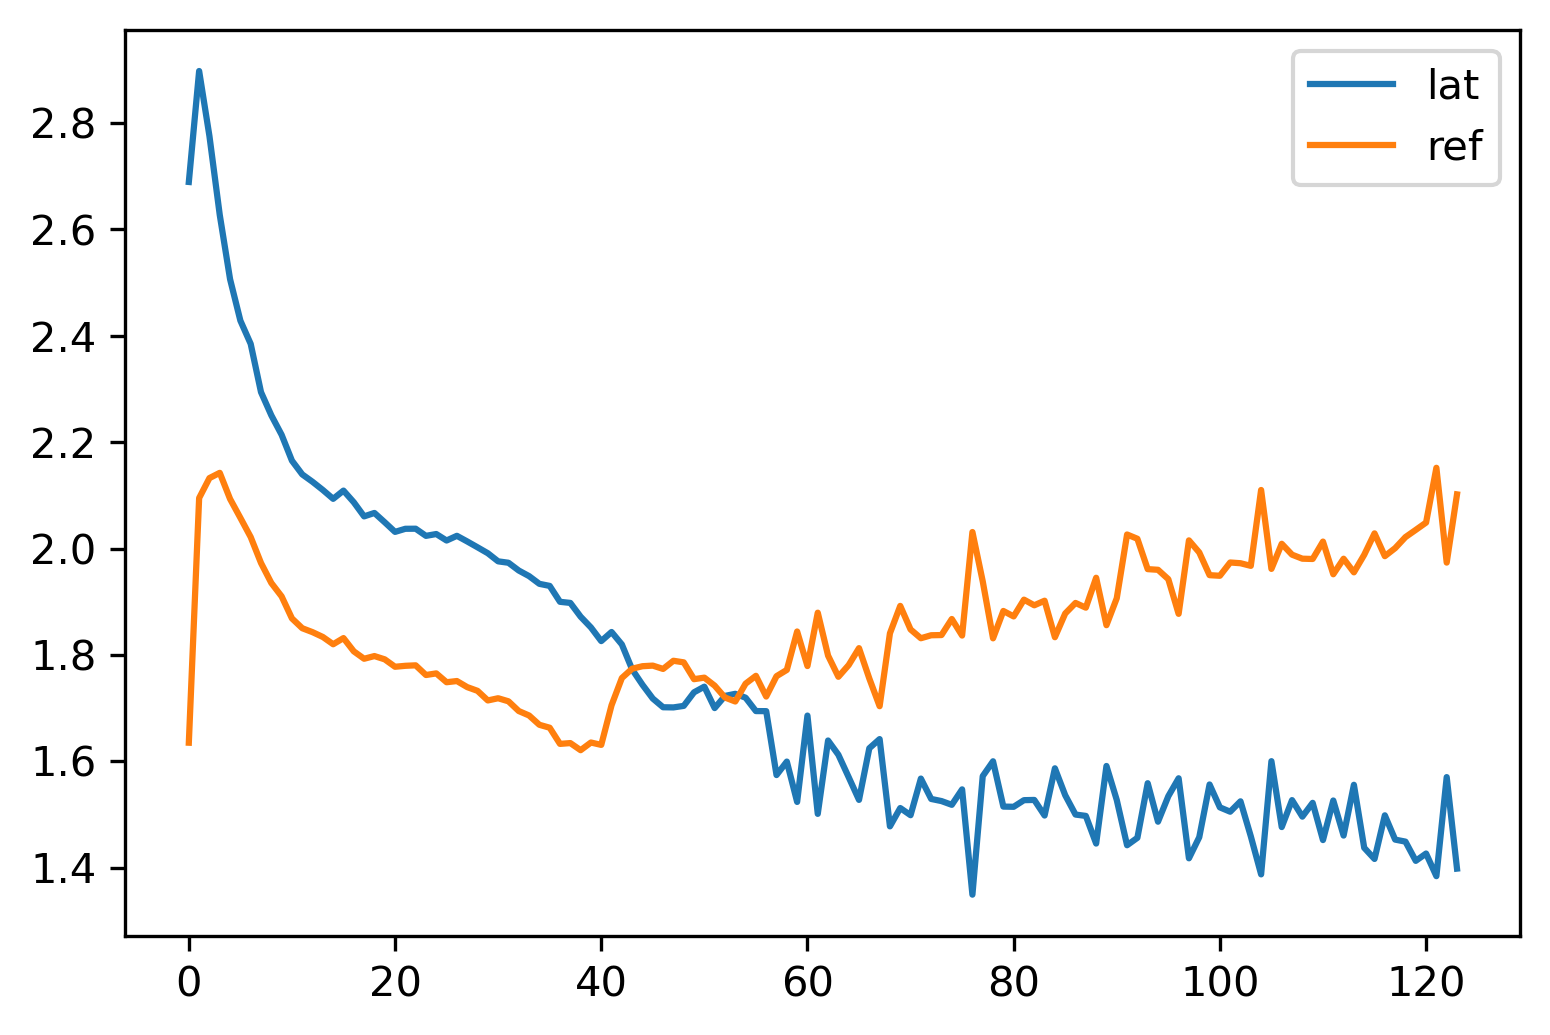

In [19]:
plt.plot(solver.g_latent_adv_losses, label='lat')
plt.plot(solver.g_ref_adv_losses, label='ref')
plt.legend();

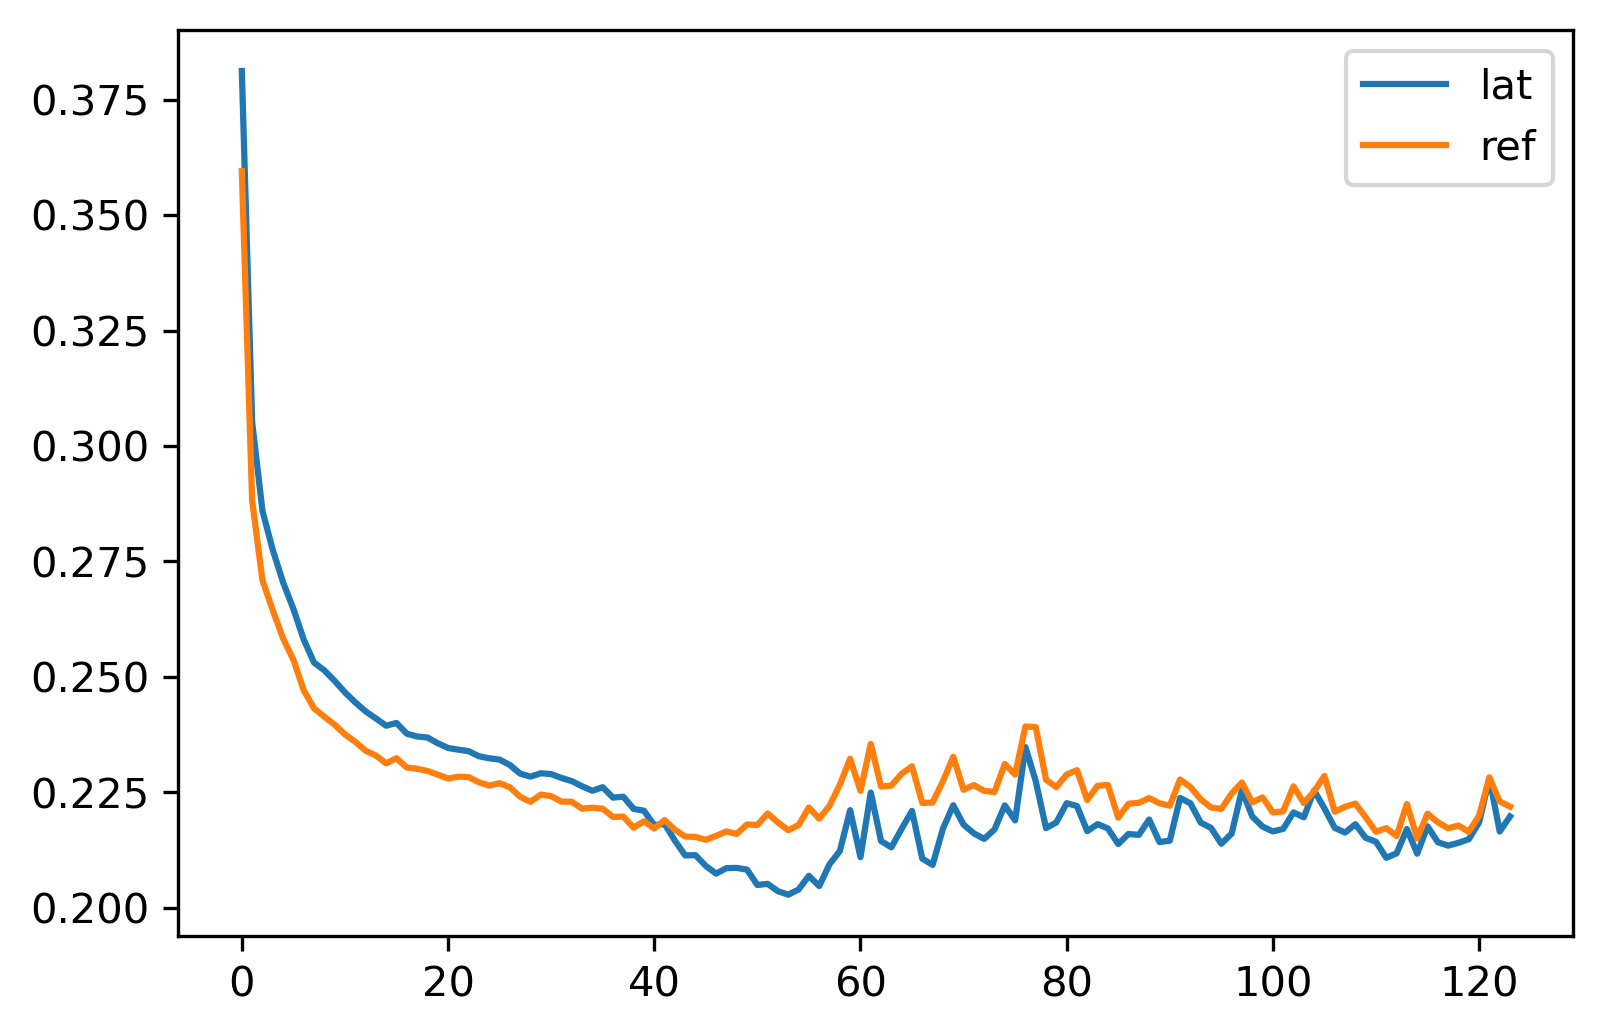

In [20]:
plt.plot(solver.g_latent_cyc_losses, label='lat')
plt.plot(solver.g_ref_cyc_losses, label='ref')
plt.legend();

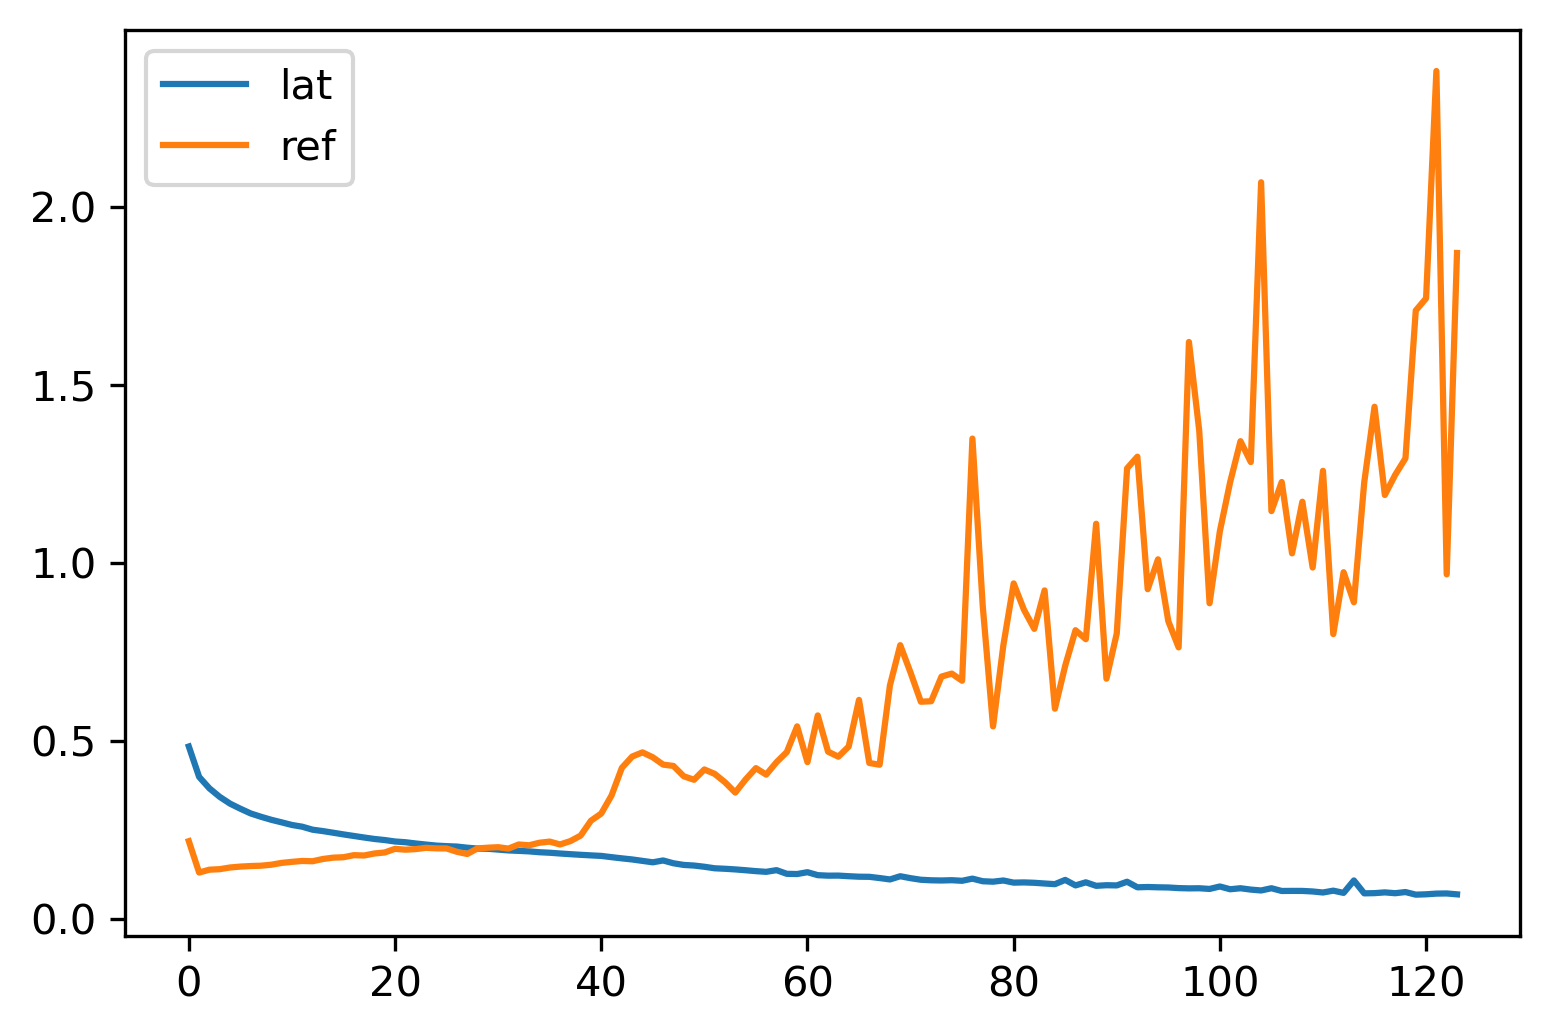

In [22]:
plt.plot(solver.g_latent_sty_losses, label='lat')
plt.plot(solver.g_ref_sty_losses, label='ref')
plt.legend();

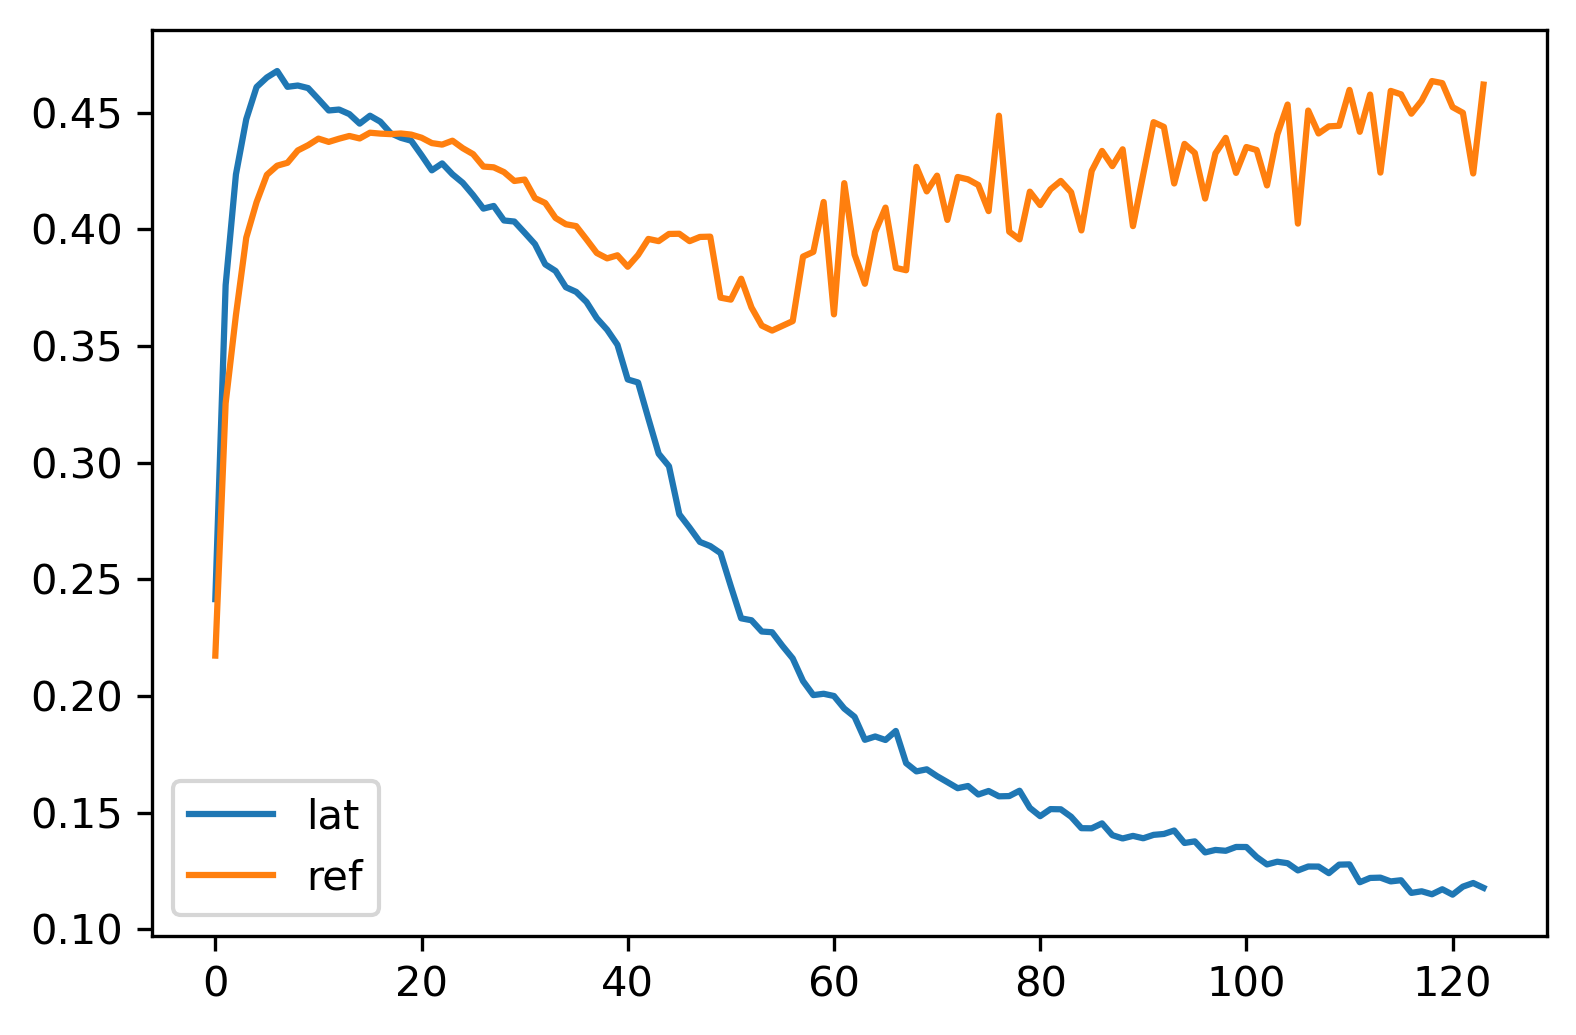

In [28]:
plt.plot(solver.g_latent_ds_losses, label='lat')
plt.plot(solver.g_ref_ds_losses, label='ref')
plt.legend();

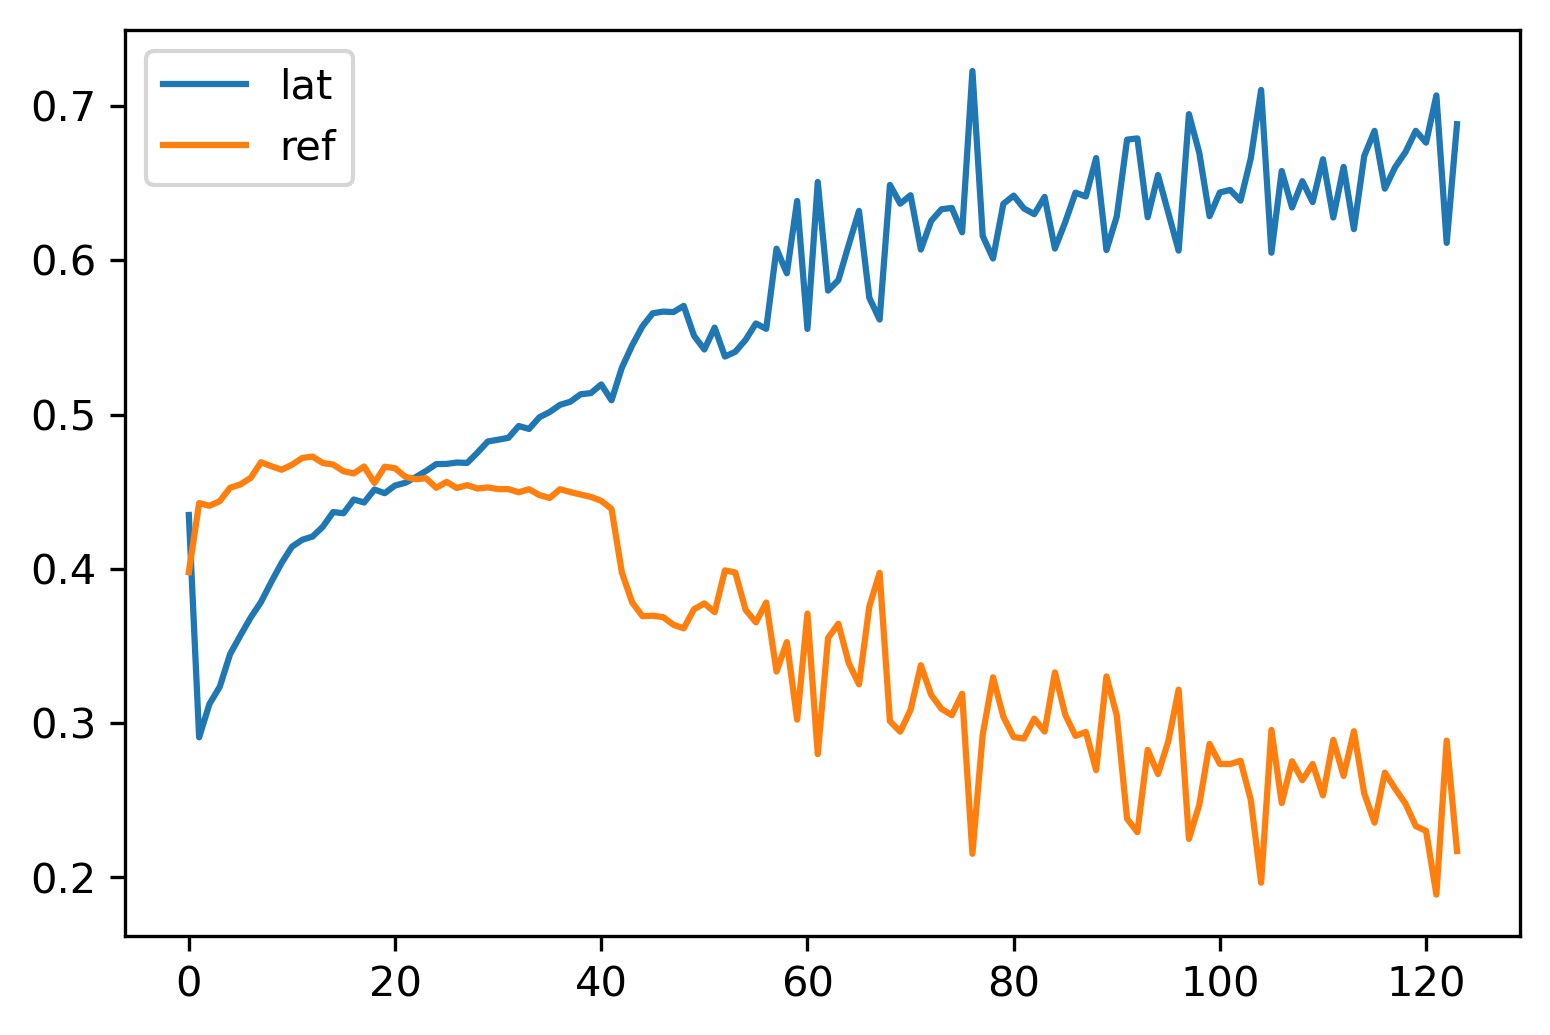

In [23]:
plt.plot(solver.d_fake_latent_losses, label='lat')
plt.plot(solver.d_fake_ref_losses, label='ref')
plt.legend();

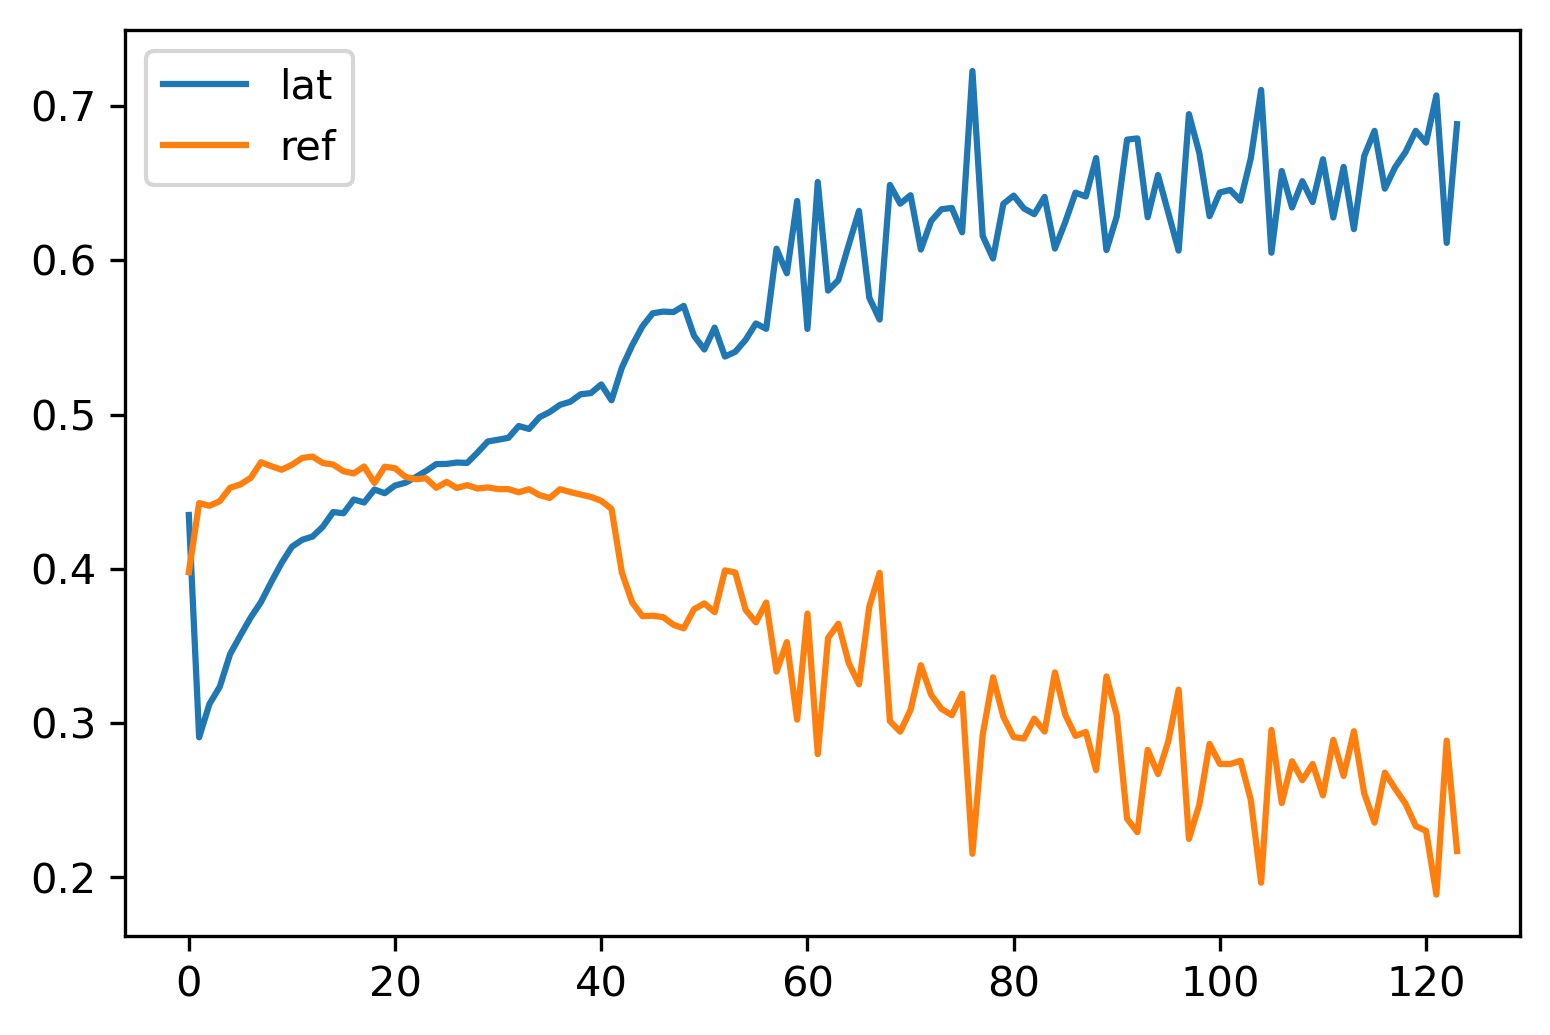

In [27]:
plt.plot(solver.d_fake_latent_losses, label='lat')
plt.plot(solver.d_fake_ref_losses, label='ref')
plt.legend();

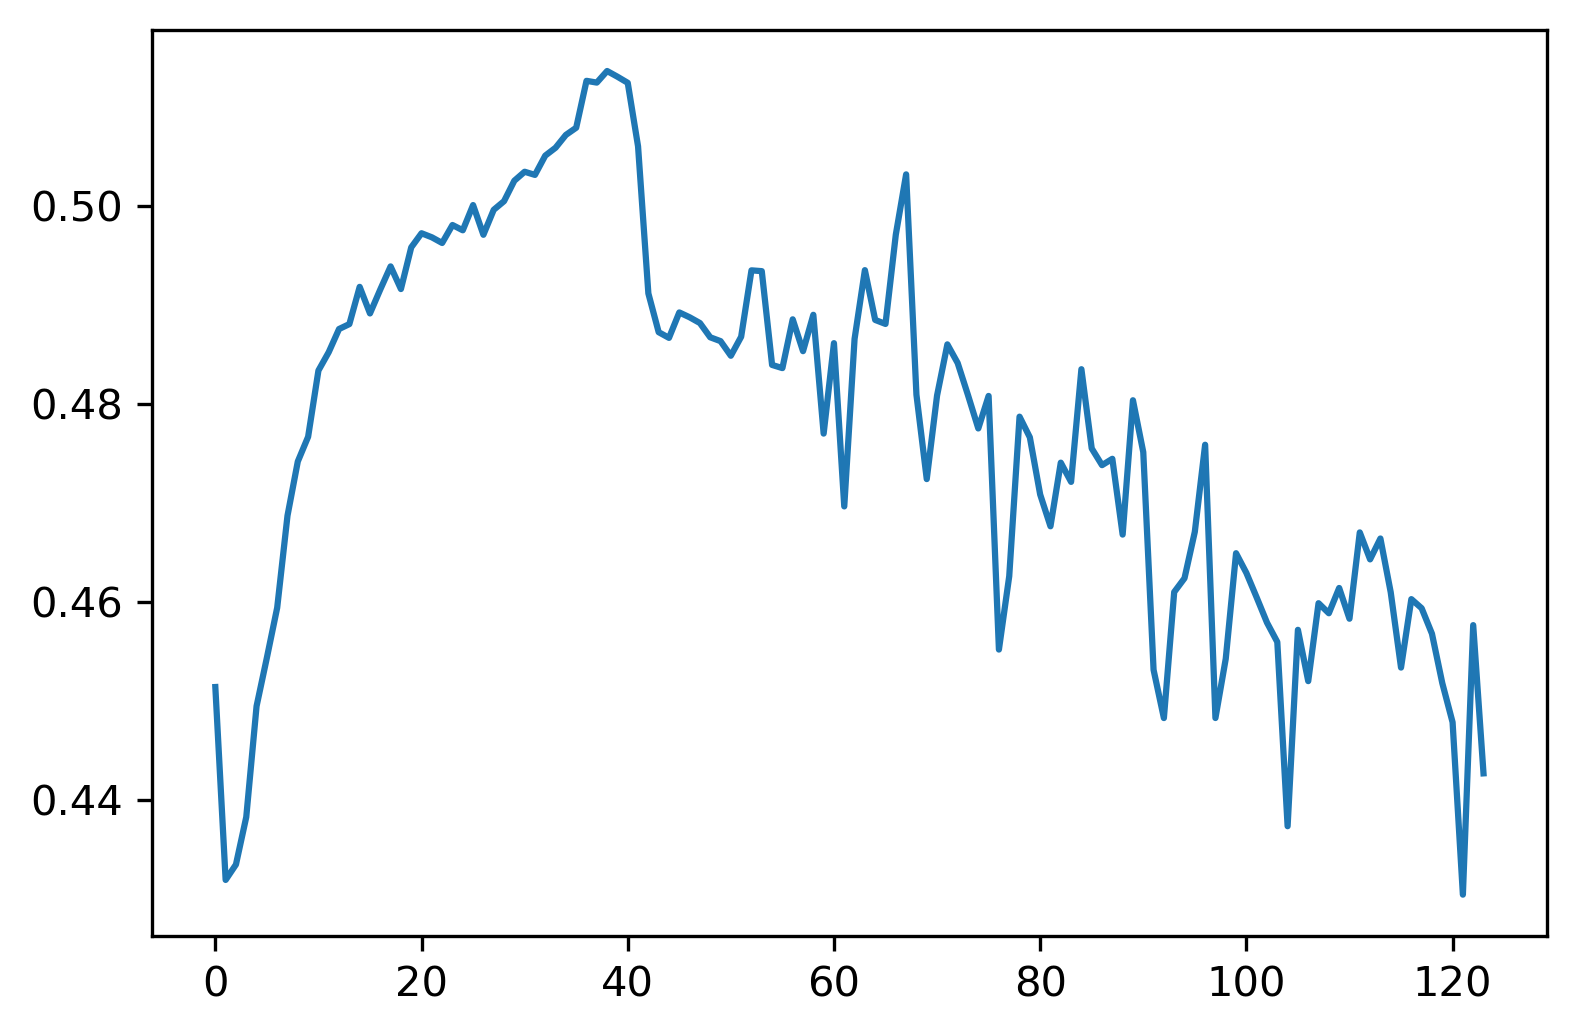

In [26]:
plt.plot(solver.d_real_losses, label='real')


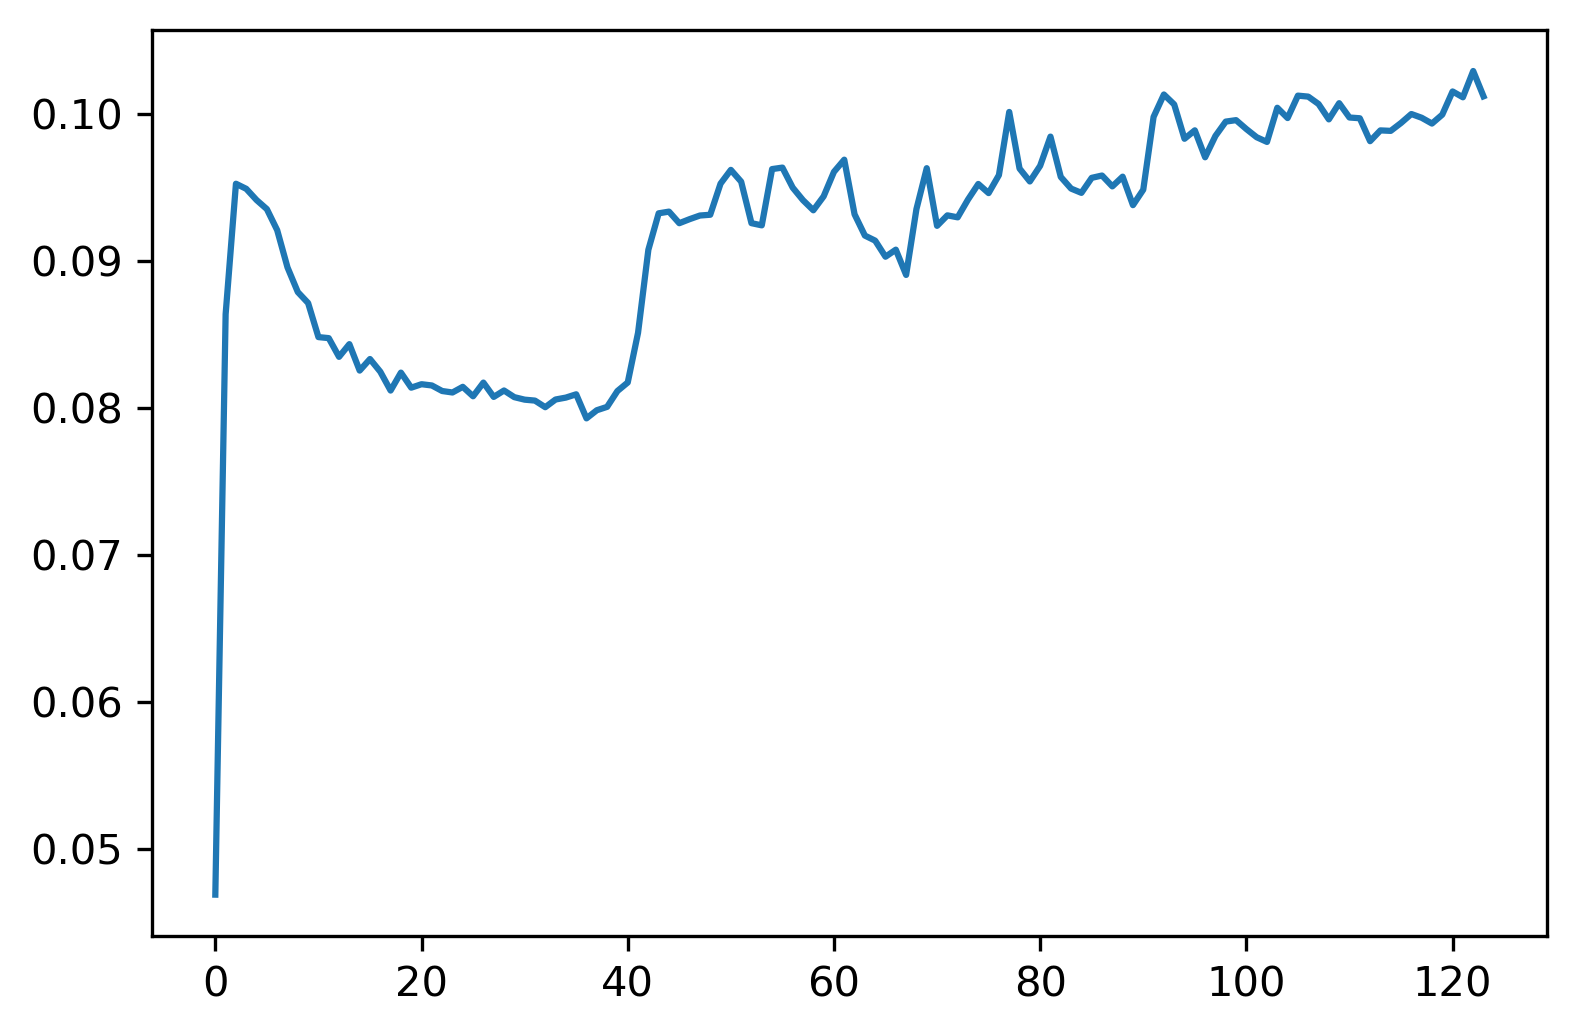

In [25]:
plt.plot(solver.d_reg_losses, label='reg')


In [2]:
X0 = np.concatenate([np.load('X0_train_clean_48.npy'), np.load('X0_val_clean_48.npy')])
X1 = np.concatenate([np.load('X1_train_clean_48.npy'), np.load('X1_val_clean_48.npy')])

X = np.concatenate((X0, X1))
y = np.concatenate((np.zeros(len(X0)), np.ones(len(X1)))).astype(np.long)

In [ ]:
solver = Solver(X, y, 2)
solver.train(10, 16)

In [14]:
def imshow(img):
    img = img.numpy()[0]
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

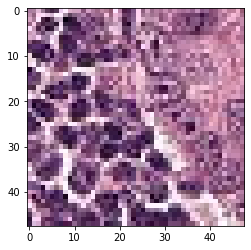

In [32]:
i = np.random.randint(len(X0))
x_ref = torch.from_numpy(X0[i][None])
imshow(x_ref)

torch.Size([1, 3, 48, 48])

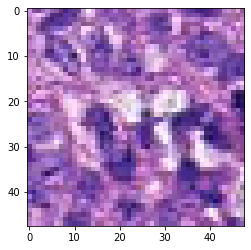

In [40]:
i = np.random.randint(len(X1))
x_real = torch.from_numpy(X1[i][None])
imshow(x_real)
x_real.shape

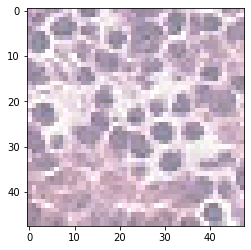

In [62]:
y_trg = torch.tensor([0]).cuda()
# s_trg = solver.style_encoder(x_ref.cuda(), y_trg)

z = torch.randn(1, solver.latent_dim).cuda()
s_trg = solver.mapping_network(z, y_trg)

x_result = ((1+solver.G(x_real.cuda(), s_trg))/2).clamp_(0, 1)
imshow(x_result.detach().cpu())

In [61]:
((x_result+1)/2).min()

tensor(0.4760, device='cuda:0', grad_fn=<MinBackward1>)